**Предварительная настройка**


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random

In [3]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [4]:
work_dir = "drive/MyDrive/Colab Notebooks/samsung/"
os.listdir(work_dir)

['styles.csv',
 'compressed_imgs',
 'test',
 'model_class_copy.ipynb',
 'model_class_test_model.ipynb',
 '18classes',
 'old18class',
 'old_dataset',
 'train',
 'val',
 'model_class.ipynb']

Работа с датасетом

In [5]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = os.listdir(work_dir + val_dir)
print(len(class_names))

28


In [6]:
print(sorted(class_names))

['Бейсболка', 'Блуза', 'Брюки', 'Бюстгальтер', 'Ветровка', 'Джемпер', 'Джинсы', 'Жилет', 'Комбинезон', 'Купальник', 'Куртка', 'Пальто', 'Перчатки', 'Пиджак', 'Плавки', 'Платье', 'Рубашка', 'Рюкзак и Мешок', 'Свитер', 'Сумка', 'Тайтсы и Леггинсы', 'Футболка и Топ', 'Халат', 'Худи', 'Шапка', 'Шорты', 'Шуба', 'Юбка']


In [7]:
# os.listdir(work_dir+train_dir)
# for d in os.listdir(work_dir + "train"):
#     # print(work_dir + "val/" + d)
#     for file in os.listdir(work_dir + "train/" + d):
#         os.remove(work_dir + "train/" + d +"/" + file)
#     os.rmdir(work_dir + "train/" + d)

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomInvert(0.3),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        # transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(work_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(image_datasets['val'])

# img_datasets = dict()
# img_datasets['train'], img_datasets['val'] = torch.utils.data.random_split(image_datasets, (round(0.8*len(image_datasets)), round(0.2*len(image_datasets))))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40,
                                             shuffle=True, num_workers=40)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

Dataset ImageFolder
    Number of datapoints: 1155
    Root location: drive/MyDrive/Colab Notebooks/samsung/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['Бейсболка', 'Блуза', 'Брюки', 'Бюстгальтер', 'Ветровка', 'Джемпер', 'Джинсы', 'Жилет', 'Комбинезон', 'Купальник', 'Куртка', 'Пальто', 'Перчатки', 'Пиджак', 'Плавки', 'Платье', 'Рубашка', 'Рюкзак и Мешок', 'Свитер', 'Сумка', 'Тайтсы и Леггинсы', 'Футболка и Топ', 'Халат', 'Худи', 'Шапка', 'Шорты', 'Шуба', 'Юбка']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
len(dataloaders["train"])

143

In [10]:
dataloaders['train'], len(dataloaders['val'])

(<torch.utils.data.dataloader.DataLoader at 0x7fa78e4dc410>, 29)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


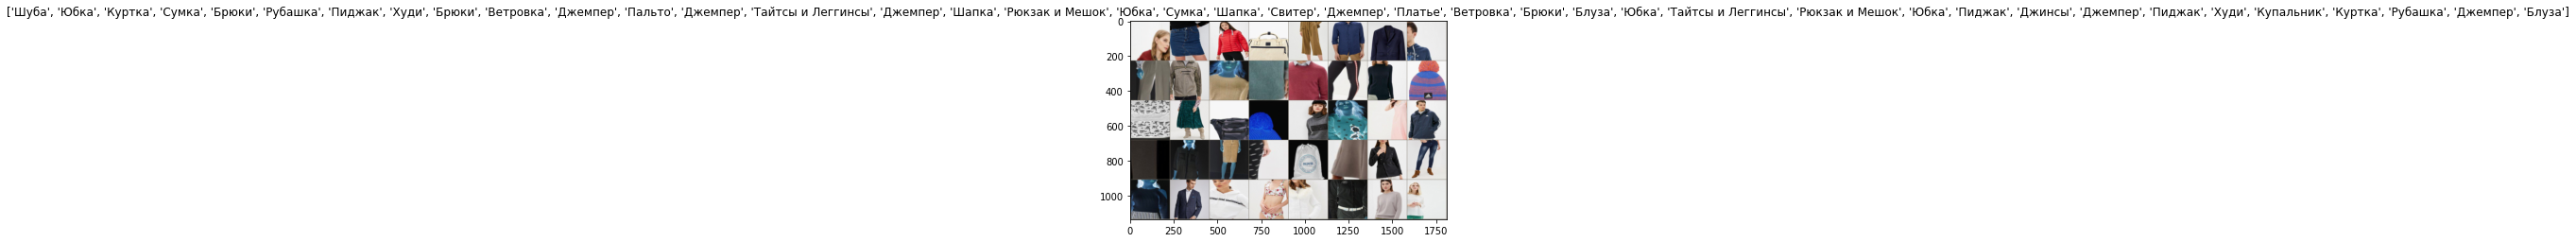

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
classes.shape

torch.Size([40])

In [14]:
len(os.listdir(work_dir+'train'))

28

**Тренировка модели**

In [15]:
def train_model(model, loss, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = dataloaders['train']
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = dataloaders['val']
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [16]:
# print(dir(models.models.mobilenet_v3_large(pretrained=True)))

In [17]:
model = models.mobilenet_v3_large(pretrained=True, progress=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

# model.classifier[-1] = nn.Linear(1280, 18)

model.classifier[-1] = torch.nn.Sequential(
            torch.nn.Linear(1280, 560),
            torch.nn.GELU(),
            torch.nn.Linear(560, 28))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, amsgrad=True)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


  0%|          | 0/143 [00:15<?, ?it/s]


RuntimeError: ignored

In [ ]:
model.eval()


In [ ]:
test_dataset = torchvision.datasets.ImageFolder(work_dir+"test", data_transforms['val'])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5, shuffle=False, num_workers=0)

In [ ]:
import time

def visualize_model(model, num_images=11):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            # print(outputs)
            _, preds = torch.max(outputs, 1)
            
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model.to(device),num_images=17)

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))
class_names = test_dataset.classes

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in class_names])

In [24]:
from torch.utils.mobile_optimizer import optimize_for_mobile

model.eval()
model_ft=model.to(torch.device("cpu"))
#model_ft=torch.quantization.convert(model_ft)
#torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
script_model.save(work_dir+"MobileNetV3_28class_v5.1"+".pt")
# traced_script_module = torch.jit.trace(model_ft,input_tensor)
# traced_script_module_optimized = optimize_for_mobile(traced_script_module)
# traced_script_module_optimized._save_for_lite_interpreter(work_dir+"article_type_tst2"+".ptl")

In [25]:
# model.eval()
# model_ft=model.to(torch.device("cpu"))
# #model_ft=torch.quantization.convert(model_ft)
# #torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
# input_tensor = torch.rand(1,3,224,224)
# script_model = torch.jit.trace(model_ft,input_tensor)
# script_model.save(work_dir+"article_type"+".pt")

In [26]:
!nvidia-smi

Sat Oct 22 17:39:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    31W /  70W |   1560MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------